In [22]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [23]:
num_epochs = 20
total_series_length = 50000
truncated_backprop_length = 15
num_classes = 2
echo_step = 3
batch_size = 5
state_size = 4
num_layers = 3
num_batches = total_series_length//batch_size//truncated_backprop_length

save_path = 'RNN_model_dir\\RNN_002.ckpt'
#save_path = '' 

In [24]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  
    y = y.reshape((batch_size, -1))

    return (x, y)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

In [32]:
tf.reset_default_graph()

batchX_placeholder = tf.placeholder(tf.float32, [None,truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [None,truncated_backprop_length])
init_state = tf.placeholder(tf.float32,[num_layers,2,None,state_size])

c_batch_size = tf.shape(batchX_placeholder)[0]
state_by_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(state_by_layer_list[idx][0],state_by_layer_list[idx][1]) for idx in range(num_layers)]
)

labels_series = tf.unstack(batchY_placeholder, axis=1)

Wyh = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
by = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)
units = []
for k in range(num_layers):
    c_cell = tf.contrib.rnn.BasicLSTMCell(state_size,state_is_tuple=True)
    c_cell = tf.nn.rnn_cell.DropoutWrapper(c_cell,output_keep_prob=0.8)
    units.append(c_cell)
cell = tf.contrib.rnn.MultiRNNCell(units,state_is_tuple=True)
states_series,current_state = tf.nn.dynamic_rnn(cell,tf.expand_dims(batchX_placeholder,-1),initial_state=rnn_tuple_state)
states_series = tf.reshape(states_series,[-1,state_size])
logits = tf.matmul(states_series,Wyh)+by
labels = tf.reshape(batchY_placeholder,[-1])
logits_series = tf.unstack(tf.reshape(logits,[c_batch_size,truncated_backprop_length,num_classes]),axis=1)
pred_series = [tf.nn.softmax(logit) for logit in logits_series]

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

New epoch 0
Step  0 , loss =  0.693149
Step  100 , loss =  0.682934
Step  200 , loss =  0.665172
Step  300 , loss =  0.609028
Step  400 , loss =  0.629301
Step  500 , loss =  0.469945
Step  600 , loss =  0.390229
New epoch 1
Step  0 , loss =  0.386126
Step  100 , loss =  0.101079
Step  200 , loss =  0.0613279
Step  300 , loss =  0.203992
Step  400 , loss =  0.0261022
Step  500 , loss =  0.0152496
Step  600 , loss =  0.0167579
New epoch 2
Step  0 , loss =  0.22251
Step  100 , loss =  0.00619866
Step  200 , loss =  0.120857
Step  300 , loss =  0.0124429
Step  400 , loss =  0.0137864
Step  500 , loss =  0.0809637
Step  600 , loss =  0.0390694
New epoch 3
Step  0 , loss =  0.405672
Step  100 , loss =  0.0152747
Step  200 , loss =  0.00338302
Step  300 , loss =  0.0307674
Step  400 , loss =  0.0829369
Step  500 , loss =  0.013256
Step  600 , loss =  0.000632625
New epoch 4
Step  0 , loss =  0.409837
Step  100 , loss =  0.0777315
Step  200 , loss =  0.0312919
Step  300 , loss =  0.00192311
S

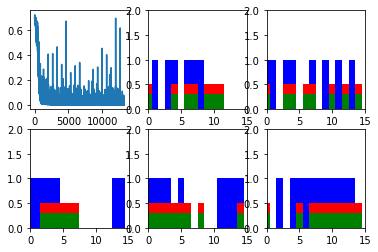

In [34]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []
    
    for epoch_index in range(num_epochs):
        x,y = generateData()
        c_state = np.zeros([num_layers,2,batch_size,state_size])
        
        print('New epoch %d'%(epoch_index))
        for batch_index in range(num_batches):
            start_index = batch_index*truncated_backprop_length
            stop_index = start_index + truncated_backprop_length
            
            batchX = x[:,start_index:stop_index]
            batchY = y[:,start_index:stop_index]
            
            c_loss,_,c_state,pr_series = sess.run([total_loss,train_step,current_state,pred_series],feed_dict={
                batchX_placeholder: batchX,
                batchY_placeholder: batchY,
                init_state: c_state
            })
            
            loss_list.append(c_loss)
            
            if batch_index%100==0:
                print('Step ',batch_index,", loss = ",c_loss)
                plot(loss_list,pr_series,batchX,batchY)
    
    if save_path is not '':
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_path)
                
plt.ioff()
plt.show()

In [35]:
with tf.Session() as sess:
    if save_path is '':
        raise Exception('No trained network selected!')
    saver = tf.train.Saver()
    saver.restore(sess,save_path)
    
    batch_size = 1
    (x,_) = generateData()
    c_state = np.zeros([num_layers,2,1,state_size])
    
    for batch_index in range(num_batches):
        start_index = batch_index*truncated_backprop_length
        stop_index = start_index + truncated_backprop_length
            
        batchX = x[:,start_index:stop_index]
            
        pr_series = sess.run([pred_series],feed_dict={
            batchX_placeholder: batchX,
            init_state:c_state
        })
        pr_numpy = np.array(pr_series)[0]
        out_mat = np.zeros((1,truncated_backprop_length))
        
        print(batchX)
        for row in range(pr_numpy.shape[1]):
            prob_row = np.reshape(pr_numpy[:,row,:],(truncated_backprop_length,2))
            out_row = np.zeros((1,truncated_backprop_length))
            for k in range(truncated_backprop_length):
                if prob_row[k,0]<prob_row[k,1]:
                    out_row[0,k]=1
            out_mat[row,:]=out_row
        print(np.roll(out_mat,-echo_step,axis=1))
        print('\n')

INFO:tensorflow:Restoring parameters from RNN_model_dir\RNN_002.ckpt
[[1 0 0 1 1 0 0 0 0 1 1 1 0 0 0]]
[[ 1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.]]


[[0 1 1 1 1 0 1 1 0 0 0 1 1 0 1]]
[[ 0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.]]


[[0 0 1 0 1 1 0 1 1 1 1 0 1 0 1]]
[[ 0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.]]


[[1 0 1 0 0 1 1 1 1 1 1 1 0 0 0]]
[[ 1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.]]


[[1 0 0 0 0 1 1 0 1 1 1 0 0 1 1]]
[[ 1.  0.  0.  0.  0.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.]]


[[1 1 0 0 0 0 1 1 1 1 1 1 1 0 1]]
[[ 1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  0.]]


[[1 1 1 1 0 1 0 0 1 1 0 0 0 0 0]]
[[ 1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.]]


[[1 1 0 0 1 1 1 1 1 0 1 1 1 0 0]]
[[ 1.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.]]


[[0 0 1 0 1 1 0 1 0 0 0 1 1 0 0]]
[[ 0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.  1.  1.  1.]]


[[1 1 1 1 1 0 0 0 0 1 0 1 0 1 0

[[0 1 0 0 1 0 1 0 0 0 0 0 1 0 0]]
[[ 0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


[[0 0 0 0 1 0 0 1 1 0 1 0 0 1 1]]
[[ 0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.  1.]]


[[0 1 0 1 1 0 1 0 1 0 0 1 1 1 1]]
[[ 0.  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]]


[[0 1 1 1 1 0 0 1 0 0 1 0 1 1 0]]
[[ 0.  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.]]


[[0 0 0 1 1 1 0 1 1 1 0 1 0 1 1]]
[[ 0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  0.  0.]]


[[0 1 1 1 1 0 0 1 0 1 1 1 1 0 1]]
[[ 0.  1.  1.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.]]


[[1 1 1 1 0 1 1 1 1 0 0 1 0 0 0]]
[[ 1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.]]


[[1 1 0 0 0 0 0 0 1 0 1 1 1 0 1]]
[[ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.]]


[[0 1 0 0 1 1 1 0 0 0 1 1 1 1 0]]
[[ 0.  1.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.]]


[[0 0 1 1 0 1 1 1 0 1 1 1 1 1 0]]
[[ 0.  0.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.]]




[[0 0 1 0 0 1 0 1 0 0 1 0 1 1 1]]
[[ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.]]


[[0 0 1 0 1 1 1 1 0 1 0 1 0 0 0]]
[[ 0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.]]


[[1 0 0 1 0 0 0 0 0 1 1 1 1 1 1]]
[[ 1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.]]


[[1 0 0 0 0 0 0 1 0 1 1 1 0 1 1]]
[[ 1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]]


[[0 1 0 1 1 0 1 0 1 1 1 1 1 0 1]]
[[ 0.  1.  0.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.]]


[[0 0 0 0 0 0 0 1 0 1 1 0 1 0 1]]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.]]


[[0 1 1 1 0 1 0 0 0 1 0 1 0 1 1]]
[[ 0.  1.  1.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.]]


[[0 0 1 1 0 1 0 1 1 0 0 1 1 0 1]]
[[ 0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  1.]]


[[0 1 0 0 0 1 0 0 1 1 1 0 1 0 0]]
[[ 0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.]]


[[0 1 0 1 1 0 1 1 1 1 1 0 0 0 1]]
[[ 0.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.]]




[[1 1 1 0 0 1 1 1 1 1 1 1 1 1 0]]
[[ 1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.]]


[[0 1 1 1 0 1 0 1 1 1 1 0 1 0 1]]
[[ 0.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.]]


[[1 1 1 1 0 1 1 1 0 0 1 1 1 0 1]]
[[ 1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.]]


[[0 1 1 1 1 1 1 1 0 0 1 1 0 1 1]]
[[ 0.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  0.]]


[[1 0 1 0 0 1 1 0 1 0 0 1 0 0 1]]
[[ 1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.]]


[[0 0 0 1 1 1 1 0 1 0 0 1 0 1 0]]
[[ 0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  1.]]


[[1 0 1 0 0 0 1 0 0 0 0 1 1 0 0]]
[[ 1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.]]


[[0 0 1 0 1 0 1 1 0 1 0 0 0 0 0]]
[[ 0.  0.  1.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.]]


[[0 0 0 0 0 1 0 0 1 1 0 1 1 1 0]]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.]]


[[0 1 0 1 1 0 0 1 1 1 0 0 1 1 0]]
[[ 0.  1.  0.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.]]




[[1 1 1 0 1 0 0 0 0 1 0 1 0 0 1]]
[[ 1.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.]]


[[0 1 0 1 1 1 0 1 0 1 1 1 1 0 0]]
[[ 0.  1.  0.  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.]]


[[1 1 0 0 0 0 0 1 0 1 1 1 1 1 0]]
[[ 1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]]


[[0 0 1 0 1 0 0 0 0 0 0 1 0 1 1]]
[[ 0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.]]


[[0 1 0 0 0 1 0 1 0 1 0 0 0 1 0]]
[[ 0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.]]


[[0 1 0 1 0 0 1 0 0 0 1 1 1 0 0]]
[[ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.]]


[[1 0 1 0 0 1 1 1 1 0 0 0 0 1 0]]
[[ 1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]]


[[1 0 1 1 0 0 1 1 1 1 0 0 1 1 1]]
[[ 1.  0.  1.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.]]


[[1 1 1 0 0 0 0 0 1 0 1 0 1 0 1]]
[[ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.]]


[[1 1 0 1 1 0 1 1 0 0 0 0 1 1 1]]
[[ 1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.]]




[[1 1 1 0 1 0 0 0 1 0 0 1 1 0 1]]
[[ 1.  1.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.]]


[[1 0 1 1 1 1 0 0 1 1 1 0 0 0 1]]
[[ 1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.]]


[[0 1 0 1 0 1 1 0 0 0 0 1 0 0 0]]
[[ 0.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.]]


[[0 0 0 0 0 0 0 1 1 1 1 0 1 1 1]]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.]]


[[0 0 0 0 0 1 0 0 0 0 0 1 1 1 1]]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.]]


[[0 0 0 0 0 1 0 1 0 1 0 1 1 1 1]]
[[ 0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.]]


[[0 0 0 1 0 0 1 1 1 1 0 1 0 1 0]]
[[ 0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.]]


[[0 1 1 1 0 0 0 1 0 1 0 1 1 0 1]]
[[ 0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  0.]]


[[0 0 1 1 0 0 1 1 0 1 1 1 1 1 1]]
[[ 0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.]]


[[1 1 1 0 1 0 1 0 0 1 1 1 1 1 0]]
[[ 1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.]]




[[1 1 1 0 1 1 0 1 0 0 0 1 0 1 1]]
[[ 1.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.]]


[[1 0 1 1 1 0 1 0 1 0 0 1 1 0 0]]
[[ 1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]]


[[0 0 0 1 0 1 1 1 1 0 1 1 0 1 0]]
[[ 0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.]]


[[1 0 1 1 0 0 0 1 1 0 0 0 1 1 0]]
[[ 1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.]]


[[1 1 1 0 1 1 1 0 0 0 0 0 0 1 0]]
[[ 1.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


[[0 1 0 0 0 1 1 1 0 0 1 0 1 0 0]]
[[ 0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.  0.  0.]]


[[0 1 0 1 1 1 1 1 1 1 1 1 1 0 1]]
[[ 0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.]]


[[1 1 1 0 0 0 1 1 1 0 0 1 1 0 0]]
[[ 1.  1.  1.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.  0.  0.]]


[[0 1 1 1 0 1 0 0 0 0 1 1 1 0 0]]
[[ 0.  1.  1.  1.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.]]


[[0 1 0 1 1 1 0 1 0 1 0 1 1 1 1]]
[[ 0.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.]]


